In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('PBL5recommendationdata.csv',encoding='latin-1')
df.head()

C:\Users\90531\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20,33,73,106,158) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,Customers.sales_rep,Customers.rewards,Customers.profile_id,Customers.last_modified,Customers.customer_type,Orders.id,Orders.customer_id,Orders.fname,Orders.lname,Orders.company,Orders.order_number,Orders.reorder_id,Orders.external_source,Orders.external_id,Orders.currency,Orders.sales_rep,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_id,Orders.coupon_amount,Orders.gift_id,Orders.gift_amount,Orders.fee_name,Orders.fee_amount,Orders.discount_name,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.shipping_carrier,Orders.shipping_method,Orders.shipping_trans,Orders.shipping_flags,Orders.weight,Orders.tracking,Orders.payment_status,Orders.payment_date,Orders.payment_user,Orders.payment_type,Orders.payment_method,Orders.payment_amount,Orders.purchase_order,Orders.payment_id,Orders.payment_code,Orders.payment_ref,Orders.status,Orders.placed_date,Orders.updated_date,Orders.shipped_date,Orders.comments,Orders.notes,Orders.registry_id,Orders.gift_message,Orders.website,Orders.mailing,Orders.flags,Orders.partial_ship,Orders.customer_type,Order_Items.id,Order_Items.parent,Order_Items.product_id,Order_Items.product_name,Order_Items.attributes,Order_Items.attribute_names,Order_Items.attribute_prices,Order_Items.qty,Order_Items.price,Order_Items.cost,Order_Items.registry_item,Order_Items.related_id,Order_Items.reorder_frequency,Order_Items.account_id,Order_Items.flags,Products.id,Products.status,Products.product_type,Products.template,Products.vendor,Products.import_id,Products.name,Products.display_name,Products.menu_name,Products.list_price,Products.price,Products.sale_price,Products.cost,Products.flags,Products.left_flag,Products.right_flag,Products.last_modified,Products.taxable,Products.shopping_gtin,Products.shopping_brand,Products.shopping_mpn,Products.shopping_gender,Products.shopping_color,Products.shopping_age,Products.shopping_flags,Products.amazon_asin,Products.amazon_type,Products.amazon_item_type,Products.amazon_price,Products.google_shopping_id,Products.google_shopping_type,Products.google_shopping_cat,Products.google_adwords,Products.shopping_cat,Products.shopping_type,Products.pricegrabber_cat,Products.shopzilla_cat,Products.thefind_cat,Products.quickbooks_id,Products.qb_edit_sequence,Products.price_break_type,Products.price_breaks,Products.short_description,Products.long_description,Products.websites,Products.video,Products.audio,Products.seo_title,Products.seo_description,Products.seo_keywords,Products.seo_header,Products.seo_footer,Products.seo_url,Products.seo_category,Products.unit,Products.packaging,Products.display_packaging,Products.multiple,Products.length,Products.width,Products.height,Products.rx,Products.latex,Products.upc,Products.msds_link,Products.msds_label,Products.lit_link,Products.lit_label,Products.hcpcs,Products.case_qty,Products.markup,Products.override_markup,Products.notes,Products.import_flags,Products.map_price,Products.features_title,Products.warranty,Products.hygienic,Products.default_quantity,Products.user_size,Products.assembly,Products.installation,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.handling_time,Products.rotation_link,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
0,797,Christy,Dill,Company0,1426018724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764306,0.0,3758,797,Christy,Dill,Company0,3758,NaN,NaN,NaN,USD,NaN,57.20,0.0,9.95,13.0,2.86,NaN,NaN,NaN,NaN,NaN,NaN,64.29,NaN,fedex,11|Ground,NaN,NaN,NaN,5.7204E+14,3.0,1.426019e+09,NaN,authorize.net,NaN,64.29,NaN,6993607863,510142,NaN,1,1426019099,1.438868e+09,1.426101e+09,NaN,Insured By Eye4Fraud,NaN,NaN,NaN,NaN,NaN,NaN,0.0,528

In [ ]:
df.shape

(4194, 181)

In [ ]:
df.columns.tolist()

In [ ]:
df=df[df['Orders.subtotal']>0] #TOPLAM HARCAMAYI GÖSTERİR.Harcama yapmayanı almıyoruz. 

In [ ]:
df=df[df['Order_Items.qty'] > 0] #0'dan çok alması lazım.                              

In [ ]:
#x['Order_Items.reorder_frequency']=x['Order_Items.reorder_frequency'].dropna(inplace=True)

In [ ]:
df['Order_Items.reorder_frequency'].dropna() #müşterinin tekrar sipariş etme sıklığı(?)

5       2.0
6       3.0
1004    1.0
1537    1.0
1607    1.0
1617    3.0
1675    1.0
1870    2.0
1875    2.0
1988    1.0
2010    1.0
2020    1.0
2022    1.0
2375    1.0
2399    4.0
2505    2.0
2516    1.0
2517    1.0
2539    1.0
2817    1.0
3134    3.0
3178    2.0
3279    1.0
3703    3.0
Name: Order_Items.reorder_frequency, dtype: float64

In [ ]:
def unique_counts(df):
   for i in df[['Order_Items.product_id','Customers.id','Customers.company']]:
       count = df[i].nunique()
       print(i, ": ", count)
unique_counts(df)
#1753 tane sipariş edilen farklı ürün var.

Order_Items.product_id :  1753
Customers.id :  3054
Customers.company :  425


In [ ]:
import datetime 
import datetime as dt
df['Customers.last_modified']=df['Customers.last_modified'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
 df['Customers.last_modified'].sort_values()

1422    1970-01-17 18:19:19
1254    1970-01-17 18:19:19
1253    1970-01-17 18:19:19
628     1970-01-17 18:19:19
1251    1970-01-17 18:19:19
               ...         
4189    1970-01-18 01:30:08
4190    1970-01-18 01:30:12
4191    1970-01-18 01:30:13
4192    1970-01-18 01:30:16
4193    1970-01-18 01:30:18
Name: Customers.last_modified, Length: 4194, dtype: object

In [ ]:
df_x = df.groupby('Customers.id').agg({'Orders.subtotal': lambda x: x.sum(),
                                        'Customers.last_modified': lambda x: ( x.max())})

In [ ]:
df_y = df.groupby(['Customers.id','Order_Items.product_id']).agg({'Orders.subtotal': lambda x: x.sum()})

In [ ]:
df_z = df_y.groupby('Customers.id').agg({'Orders.subtotal': lambda x: len(x)})

In [ ]:
rfm_table= pd.merge(df_x,df_z, on='Customers.id')

In [ ]:
rfm_table.rename(columns= {'Customers.last_modified': 'Recency',
                          'Orders.subtotal_y': 'Frequency',
                          'Orders.subtotal_x': 'Monetary'}, inplace= True)

In [ ]:
rfm_table.head()

,Monetary,Recency,Frequency
Customers.id,,,
3,88.78,1970-01-17 18:22:44,2.0
4,19.56,1970-01-17 18:22:42,1.0
5,95.14,1970-01-17 18:22:44,3.0
7,39.19,1970-01-17 18:22:43,1.0
8,59.75,1970-01-17 18:22:43,1.0


In [ ]:
rfm_table.tail()

,Monetary,Recency,Frequency
Customers.id,,,
3730,14.85,1970-01-18 01:30:08,1.0
3732,39.99,1970-01-18 01:30:12,1.0
3733,1099.00,1970-01-18 01:30:13,1.0
3735,129.99,1970-01-18 01:30:16,1.0
3736,24.54,1970-01-18 01:30:18,1.0


In [ ]:
rfm_table['Monetary'].sort_values() #en çok harcayan king customer->1043

Customers.id
3145        2.89
1648        3.64
2308        4.16
2882        4.24
2703        4.35
          ...   
1616     8291.48
1730     8452.78
2022     9502.36
1352    10383.00
1043    15041.56
Name: Monetary, Length: 3026, dtype: float64

In [ ]:
rfm_table
#Monetary->ne kadar para harcamış
#Recency->en son ne zaman uğramış
#Frequency->ne sıklıkla gelmiş

,Monetary,Recency,Frequency
Customers.id,,,
3,88.78,1970-01-17 18:22:44,2.0
4,19.56,1970-01-17 18:22:42,1.0
5,95.14,1970-01-17 18:22:44,3.0
7,39.19,1970-01-17 18:22:43,1.0
8,59.75,1970-01-17 18:22:43,1.0
...,...,...,...
3730,14.85,1970-01-18 01:30:08,1.0
3732,39.99,1970-01-18 01:30:12,1.0
3733,1099.00,1970-01-18 01:30:13,1.0


In [ ]:
x=rfm_table[['Monetary','Frequency']] 

In [ ]:
allscore=[]
allclusters=[]
sum_of_squared_distances=[]
def clust(clusters):
    for no_of_cluster in np.arange(1,clusters):
        no_of_cluster+=1
        model=KMeans(n_clusters=no_of_cluster)
        model=model.fit(x)
        pred=model.fit_predict(x)
        sum_of_squared_distances.append(model.inertia_)
        score=silhouette_score(x,pred)
        print("Number of cluster {}, silhouette {}".format(no_of_cluster,score))
        allscore.append(score)
        allclusters.append(no_of_cluster)
clust(15)

Number of cluster 2, silhouette 0.9628436996903627
Number of cluster 3, silhouette 0.9456410204750941
Number of cluster 4, silhouette 0.8775287387491917
Number of cluster 5, silhouette 0.8763522067390462
Number of cluster 6, silhouette 0.8368812286820634
Number of cluster 7, silhouette 0.8037769687186563
Number of cluster 8, silhouette 0.7087732697001415
Number of cluster 9, silhouette 0.6508164563048366
Number of cluster 10, silhouette 0.6486920532359282
Number of cluster 11, silhouette 0.6554080433403927
Number of cluster 12, silhouette 0.6560485639258774
Number of cluster 13, silhouette 0.6489198594805591
Number of cluster 14, silhouette 0.6486108814364465
Number of cluster 15, silhouette 0.6489994309447077


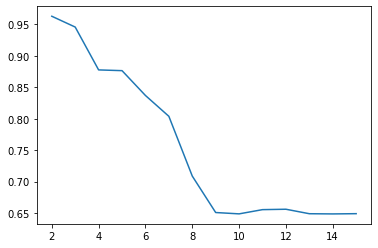

In [ ]:
plt.plot(allclusters,allscore)

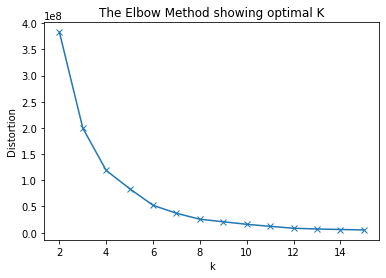

In [ ]:
plt.plot(allclusters,sum_of_squared_distances,marker='x')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal K')
plt.show()

In [ ]:
model=KMeans(n_clusters=5)

In [ ]:
model=model.fit(x)

In [ ]:
pred=model.predict(x)

In [ ]:
x['cluster']=pred

In [ ]:
x.sample(3)

,Monetary,Frequency,cluster
Customers.id,,,
3518,44.10,1.0,0
1711,202.00,2.0,0
562,55.74,1.0,0


In [ ]:
silhouette_score(x,pred)

0.8774792996839078

No handles with labels found to put in legend.


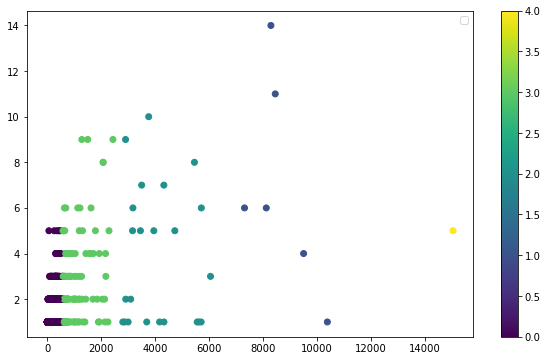

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(x['Monetary'],x['Frequency'],c=pred)
plt.legend()
plt.colorbar()
plt.show()
#sık alışveriş yapan kişiler->mavi->genelde az para harcayanlar